# Step 1: Import and install packages

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

# Step 2: Load data

In [ ]:
'''
线上下载数据
'''
import kagglehub
import os
import shutil

# Download latest version
# for dataset see: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

destination_path = "./news_detection"

os.makedirs(destination_path, exist_ok=True)

for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), destination_path)

fake_data = pd.read_csv(destination_path+"/News _dataset/Fake.csv")
real_data = pd.read_csv(destination_path+"/News _dataset/True.csv")

100%|██████████| 41.0M/41.0M [00:02<00:00, 14.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


# Step 3: Data analysis

In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


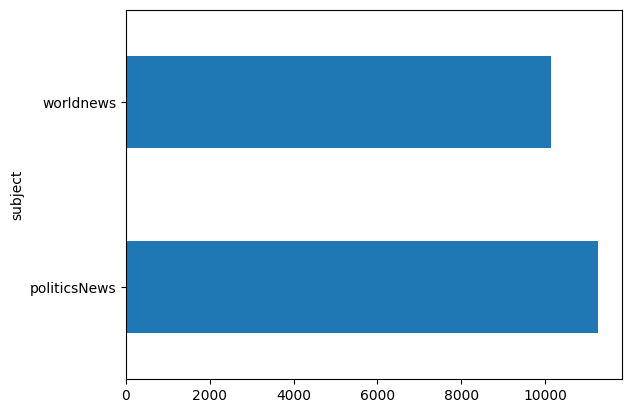

In [ ]:
# subject distribution of real news
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

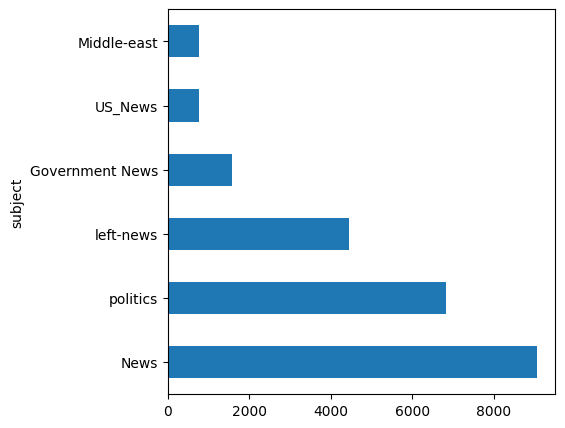

In [ ]:
# subject distribution of fake news
fake_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

## Wordcloud for real text data

In [ ]:
# for this picture see: https://user-images.githubusercontent.com/46570219/113926636-1630a300-97f5-11eb-8bf5-20723ebe27e0.png
wordcld_mask=np.array(Image.open("twitter.png"))
wordcld_text=" ".join(real_data["text"].tolist())

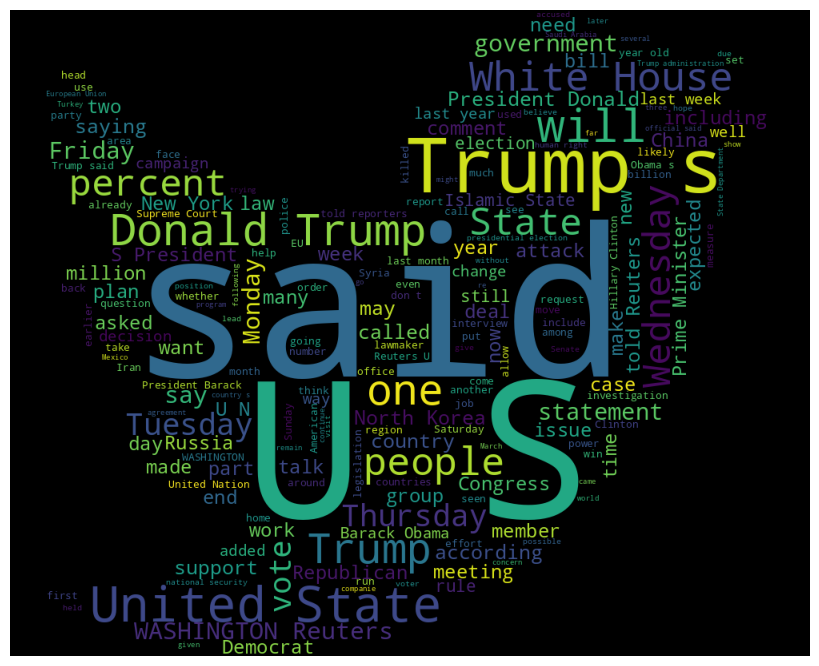

In [ ]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Wordcloud for fake text data

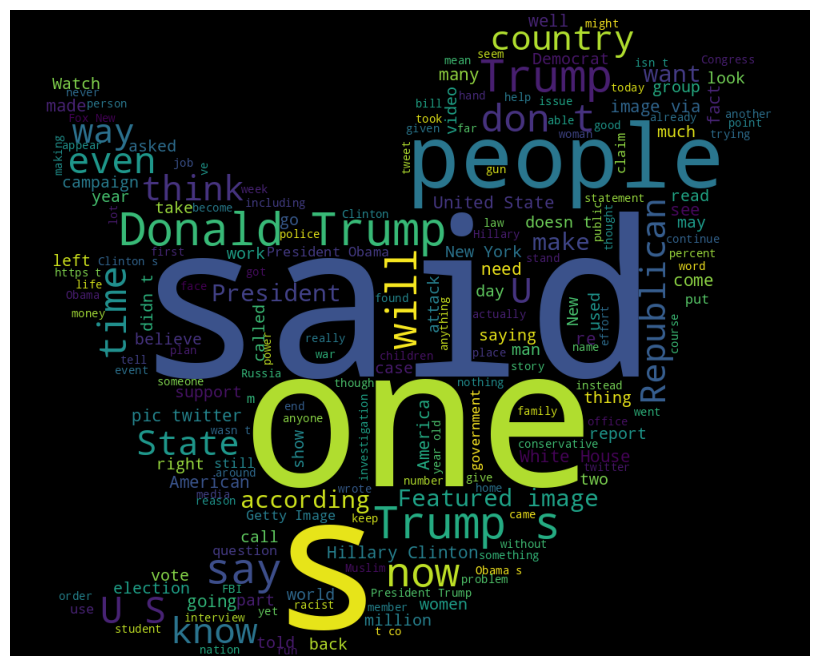

In [ ]:
fake_text=" ".join(fake_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Step 4: Preprocess

In [ ]:
# add labels to news data
fake_data["label"]="fake"
real_data["label"]="real"

# concat real and fake news data
final_data= pd.concat([fake_data,real_data])

# reset index
final_data = final_data.sample(frac=1).reset_index(drop=True)

# drop columns with few contribution to the classification task
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,NICOLE KIDMAN BREAKS RANKS With Hollywood Left...,She s travelling the world to promote her new ...,fake
1,SMUG LIBERAL LAW PROFESSOR SHUT DOWN BY TUCKER...,Tucker to sanctuary city supporter: how did a ...,fake
2,Hamas calls for Palestinian uprising over Trum...,JERUSALEM/GAZA (Reuters) - The Islamist group ...,real
3,Woman Born In NAZI GERMANY Says Trump Doesn’t ...,A woman who was born in Nazi Germany says that...,fake
4,Here’s The Disgusting Letter The FBI Sent To ...,"While Dr. Martin Luther King, Jr. s life and l...",fake
...,...,...,...
44893,Finnish police rap deputy minister for hiding ...,HELSINKI (Reuters) - Finnish police reprimande...,real
44894,WATCH: Elizabeth Warren DESTROYS Trump In Thi...,The war of words between Donald Trump and Eliz...,fake
44895,Republican Thune says bipartisan U.S. health b...,WASHINGTON (Reuters) - U.S. Senator John Thune...,real
44896,LEFTIST BABYSITTING SERVICE Allows Parents To ...,Who knew you could be a parent and still find ...,fake


<Axes: xlabel='label', ylabel='count'>

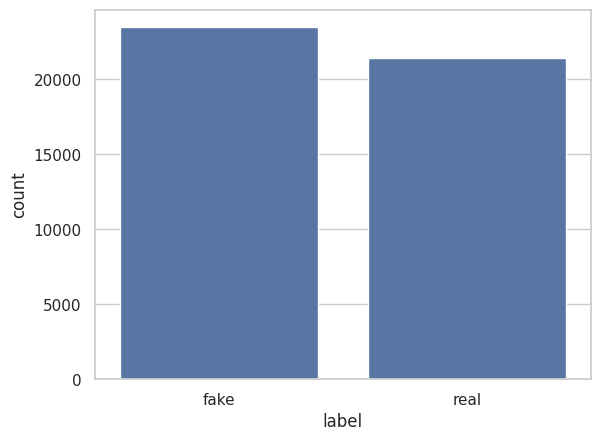

In [ ]:
# visualize the distribution of fake and real news data
sns.set_theme(style="whitegrid")
sns.countplot(x=final_data["label"])

In [ ]:
# # combine text and title as a whole text column
# final_data["text"]=final_data["title"]+final_data["text"]

# # use only text and label column in the data
# final_data=final_data[["text","label"]]

# # map real and fake news label as 1 and 0
# final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

# # take a look at final data
# final_data.head(10)

<ipython-input-5-62c154a05a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


,text,label
0,Trump Tries To Stick It To Press With Inaugur...,0
1,"Bundy Terrorists Attend A Community Meeting, ...",0
2,Trump Kills MASSIVE Infrastructure Project Th...,0
3,Couple defy Hurricane Maria on roof to save pe...,1
4,Trump Fan Openly Admits To Planning ‘Assassin...,0
5,TRUMP RESPONSE TO LEFTIST THREATS: “Get Off My...,0
6,"U.S. Senators McCain, Graham: Order may help r...",1
7,"Mexico suffers deadliest month on record, 2017...",1
8,Same-sex marriage may be law in Australia by e...,1
9,Trump says criticism of him by Republican Sena...,1


In [ ]:
'''
ablation: lemmatize版本
'''
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# 下载必要的资源
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# 初始化词形还原器
lemmatizer = WordNetLemmatizer()

# 定义一个函数，获取单词的词性
def get_wordnet_pos(word):
    """将词性映射为 WordNet 支持的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # 形容词
        'N': wordnet.NOUN, # 名词
        'V': wordnet.VERB, # 动词
        'R': wordnet.ADV   # 副词
    }
    return tag_dict.get(tag, wordnet.NOUN)  # 默认为名词

# 定义一个函数，仅进行词形还原
def lemmatize_text(text):
    # 分词
    words = word_tokenize(text)
    # 对每个单词进行词形还原
    lemmatized_words = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word)) for word in words]
    # 将词汇重新组合成句子
    return " ".join(lemmatized_words)

# combine text and title as a whole text column
final_data["text"] = final_data["title"] + final_data["text"]

# 应用到数据框的文本列
final_data["text"] = final_data["text"].apply(lemmatize_text)

# use only text and label column in the data
final_data = final_data[["text", "label"]]

# map real and fake news label as 1 and 0
final_data['label'] = final_data['label'].map({'real': 1, 'fake': 0})

# take a look at final data
final_data.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
<ipython-input-8-a0c969e74c57>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map(

,text,label
0,nicole kidman break rank with hollywood leftis...,0
1,smug liberal law professor shut down by tucker...,0
2,hamas call for palestinian uprise over trump '...,1
3,woman born in nazi germany say trump doesn ’ t...,0
4,here ’ s the disgust letter the fbi sent to ml...,0
5,democratic representative gutierrez hint at 20...,1
6,"despite showman reputation , trump inauguratio...",1
7,labor activist target midwest politician oppos...,1
8,trump loses bid to end trump university lawsui...,1
9,turkey launch investigation into u.s. prosecut...,1


In [ ]:
# define the max length of token
max_len=100

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=100, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=100, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((160,), (40,), (160,), (40,))

In [ ]:
'''
修改了sample size， 增加到1000
'''
# define the max length of token
# Tokenization max length
max_len=100

# Sample_size, maximum 20000
sample_size=1000

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=sample_size, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=sample_size, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1600,), (400,), (1600,), (400,))

# Step 5: Model training

In [ ]:
# get pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# tokenization function
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
# tokenize training and testing data
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

## Create Bert model


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# bert layer
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    # get pooled output for classification
    def call(self, inputs):
        return self.bert(inputs)[1]

# define our own create model function
def create_model(bert_model, maxlen=100):
    # input for bert of shape (batch_size, maxlen)
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    # attention mask for bert model
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # get the pooled output for bert layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # define our own layer for classification (fine-tune)
    # randomly dropout 50% of neurons while training to avoid overfit
    x = Dropout(0.5)(pooled_output)
    # transform and activate
    x = Dense(64, activation="tanh")(x)
    # dropout again
    x = Dropout(0.5)(x)
    # transform into probability from 0-1
    output = Dense(1, activation="sigmoid")(x)

    # return our model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(bert_model)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)
# use ReduceLROnPlateau for changing learning rate while training for quicker converge
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

## Kfold

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# initialize KFold of 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# store the training result for each fold
fold_history = []
val_accuracies = []
val_losses = []

# transform data into numpy array
X_input_ids = np.array(X_train_token['input_ids'])
X_attention_mask = np.array(X_train_token['attention_mask'])
Y_train_np = Y_train.to_numpy()  # Convert Y_train to NumPy array

# iterate through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_input_ids)):
    print(f"\nTraining on Fold {fold + 1}/{kf.n_splits}")

    # training data
    X_train = {
        'input_ids': X_input_ids[train_idx],
        'attention_mask': X_attention_mask[train_idx]
    }
    Y_train = Y_train_np[train_idx]

    # validation data
    X_val = {
        'input_ids': X_input_ids[val_idx],
        'attention_mask': X_attention_mask[val_idx]
    }
    Y_val = Y_train_np[val_idx]

    # create a new model for each fold
    model = create_model(bert_model, maxlen=100)
    # compile the model before using
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    # train and record the history of training
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=20,
        batch_size=30,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # acc and loss for current fold
    val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # append the history into the result
    fold_history.append(history.history)

# Kfold average acc and loss
avg_val_loss = np.mean(val_losses)
avg_val_acc = np.mean(val_accuracies)

print("K-Fold Cross-Validation Results:")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

print("K-Fold Training Complete")


Training on Fold 1/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 13s/step - accuracy: 0.4734 - loss: 0.9762 - val_accuracy: 0.5625 - val_loss: 0.6983 - learning_rate: 1.0000e-05
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 14s/step - accuracy: 0.5347 - loss: 0.8874 - val_accuracy: 0.5625 - val_loss: 0.6940 - learning_rate: 1.0000e-05
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 12s/step - accuracy: 0.5245 - loss: 0.9234 - val_accuracy: 0.5625 - val_loss: 0.6907 - learning_rate: 1.0000e-05

Training on Fold 2/5
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 12s/step - accuracy: 0.5100 - loss: 0.7524 - val_accuracy: 0.5625 - val_loss: 0.6885 - learning_rate: 1.0000e-05
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 14s/step - accuracy: 0.5564 - loss: 0.7967 - val_accuracy: 0.5625 - val_loss: 0.6882 - learning_rate: 1.0000e-05
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 11s/step - accuracy: 0.4892 - loss: 0.8612 - val_accuracy: 0.5625 - val_loss: 0.6880 - learning_rate: 1.0000e-05

Training on Fold 3/5
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 12s/step 

In [ ]:
'''
kfold函数化，增加epoch，测试3个lr，修改训练中create model
'''
from sklearn.model_selection import KFold
import numpy as np
from transformers import logging

logging.set_verbosity_error()

def k_fold_trainig(X_train_token, Y_train, learning_rates, epoch=20, batch_size=30):

  # initialize KFold of 5 fold
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  # store the training result for each fold
  fold_history = []
  val_accuracies = []
  val_losses = []
  best_lr = None
  best_loss = float('inf')

  # transform data into numpy array
  X_input_ids = np.array(X_train_token['input_ids'])
  X_attention_mask = np.array(X_train_token['attention_mask'])
  Y_train_np = Y_train.to_numpy()  # Convert Y_train to NumPy array

  for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")

    # iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_input_ids)):
        print(f"\nTraining on Fold {fold + 1}/{kf.n_splits}")

        # training data
        X_train = {
            'input_ids': X_input_ids[train_idx],
            'attention_mask': X_attention_mask[train_idx]
        }
        Y_train = Y_train_np[train_idx]

        # validation data
        X_val = {
            'input_ids': X_input_ids[val_idx],
            'attention_mask': X_attention_mask[val_idx]
        }
        Y_val = Y_train_np[val_idx]

        # create a new model for each fold
        bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        model = create_model(bert_model, maxlen=100)

        # compile the model before using
        optimizer = Adam(learning_rate=lr, epsilon=1e-08, decay=0.01,clipnorm=1.0)
        model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

        # train and record the history of training
        history = model.fit(
            x=X_train,
            y=Y_train,
            epochs=epoch,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, reduce_lr]
        )

        # acc and loss for current fold
        val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # append the history into the result
        fold_history.append(history.history)

    # Kfold average acc and loss
    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_lr = lr

    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

  print(f"Best Learning Rate: {best_lr}")
  print("K-Fold Training Complete")

# start K-Fold
learning_rates = [1e-05, 1e-04, 1e-03]
k_fold_trainig(X_train_token, Y_train, learning_rates , epoch=50, batch_size=64)


Training with Learning Rate: 1e-05

Training on Fold 1/5
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 937ms/step - accuracy: 0.5365 - loss: 0.8333 - val_accuracy: 0.5063 - val_loss: 0.7081 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/step - accuracy: 0.4965 - loss: 0.8332 - val_accuracy: 0.5250 - val_loss: 0.6935 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.5460 - loss: 0.7939 - val_accuracy: 0.5094 - val_loss: 0.6910 - learning_rate: 1.0000e-05
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - accuracy: 0.5434 - loss: 0.7612 - val_accuracy: 0.4969 - val_loss: 0.6916 - learning_rate: 1.0000e-05
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.4801 - loss: 0.8118 - val_accuracy: 0.5219 - val_loss: 0.6912 - learning_rate: 1.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4958 - loss: 0.8295
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
20/20 ━━━━━

## Original version

In [ ]:
# optimizer, learning rate and other hyperparameters
optimizer = Adam(learning_rate=1e-04, epsilon=1e-08, decay=0.01,clipnorm=1.0)

# compile our model before using it
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

with tf.device('/GPU:0'):
    # train and record history of training
    history = model.fit(
        x={
            'input_ids': X_train_token['input_ids'],
            'attention_mask': X_train_token['attention_mask']
        },
        y=Y_train,
        epochs=20,
        batch_size=30,
        validation_data=(
            {
                'input_ids': X_test_token['input_ids'],
                'attention_mask': X_test_token['attention_mask']
            },
            Y_test
        ),
        callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 636ms/step - accuracy: 0.5189 - loss: 0.8142 - val_accuracy: 0.6250 - val_loss: 0.6777 - learning_rate: 1.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.5288 - loss: 0.7959 - val_accuracy: 0.6325 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.5553 - loss: 0.7591 - val_accuracy: 0.5700 - val_loss: 0.6624 - learning_rate: 1.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.5243 - loss: 0.7781 - val_accuracy: 0.6600 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.5236 - loss: 0.7663 - val_accuracy: 0.6600 - val_loss: 0.6406 - learning_rate: 1.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.5467 - loss: 0.7585 - val_accuracy: 0.6600 - val_loss: 0.6368 - learning_rate: 1.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.53

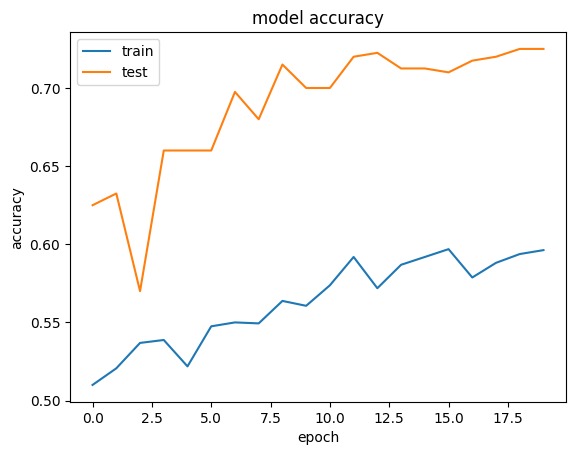

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

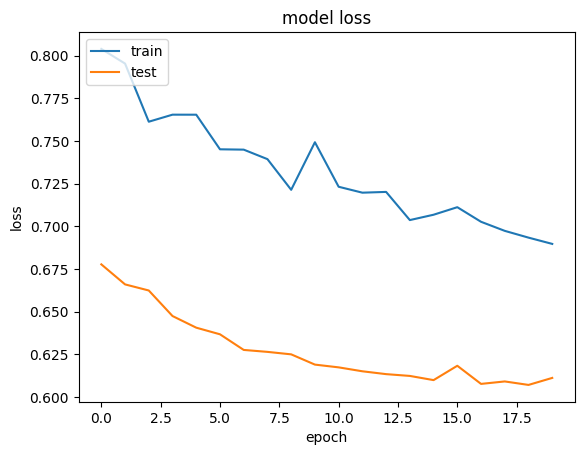

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


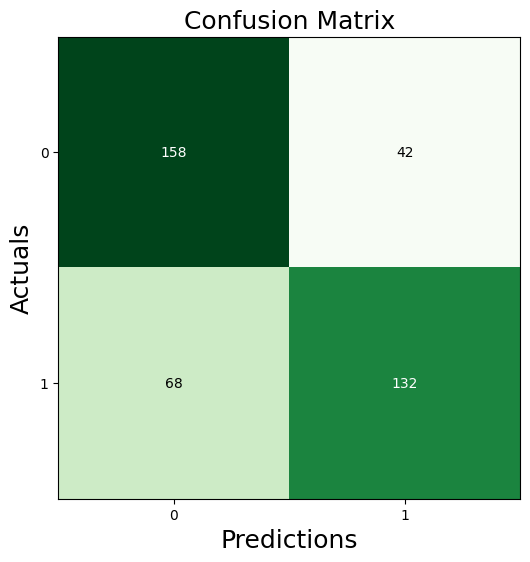

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       200
           1       0.76      0.66      0.71       200

    accuracy                           0.72       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.73      0.72      0.72       400



13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step


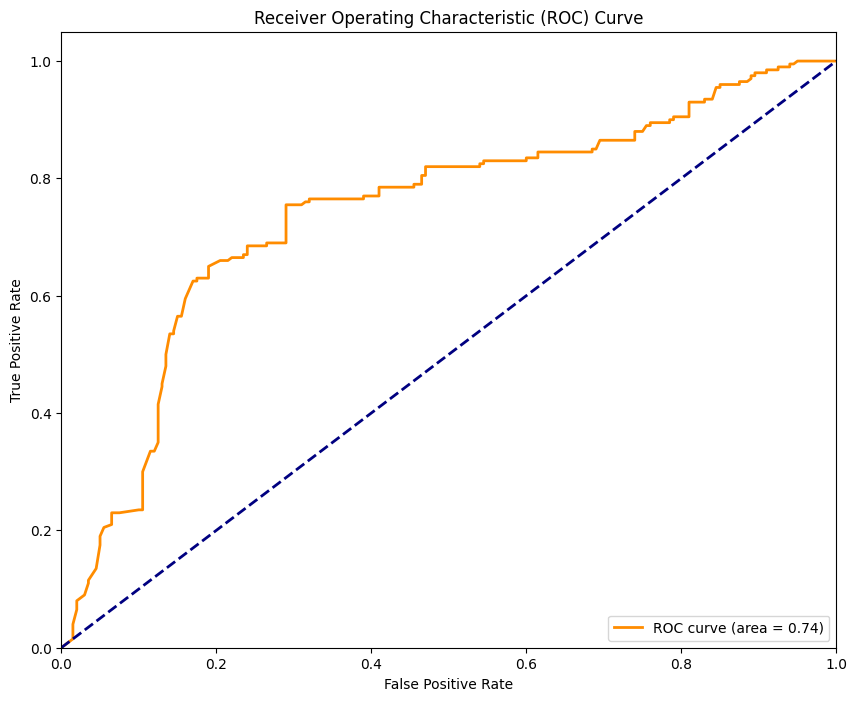

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)  # Removed indexing on y_pred_prob
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step


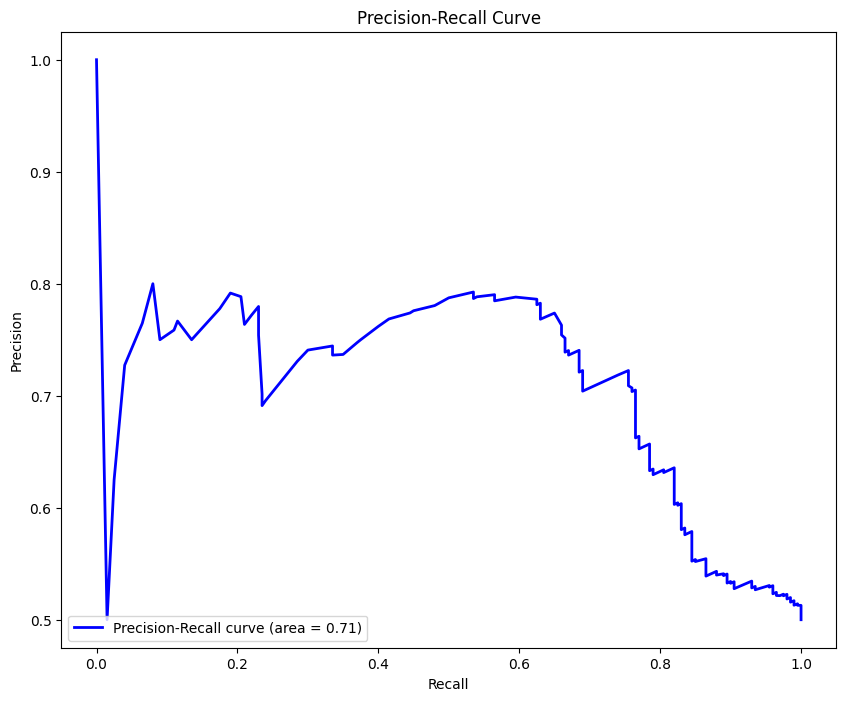

In [ ]:
from sklearn.metrics import precision_recall_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()